# Анализ результатов A/B теста дэйтинг-приложения (вариант №3)
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте, был ли эксперимент успешен в целом.\
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

## Описание данных
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры*1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins - подписка за внутреннюю валюту, other_type – другое) 

### Файлы
- users_test – информация о пользователях в тестовой группе. 
- users_control_1 – информация о пользователях в первой контрольной группе. 
- users_control_2 – информация о пользователях во второй контрольной группе . 
- transactions_test – информация о платежах пользователей в тестовой группе. 
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, normaltest, mannwhitneyu, bootstrap
import requests
from urllib.parse import urlencode
import pingouin as pg

## Подготовительный этап
### Выгрузка данных
Для скачивания файлов с Яндекс Диска воспользуемся библиотеками requests и urllib

In [4]:
def get_file_from_yadisk (public_key): #функция для получения ссылки на файл в Яндекс Диске
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [5]:
# сохраняем файлы в датафреймы
users_test = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/4XXIME4osGrMRA'), sep = ';')
users_control_1 = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/yJFydMNNGkEKfg'), sep = ';')
users_control_2 = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/br6KkQupzzTGoQ'), sep = ';')
transaction_test = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/gvCWpZ55ODzs2g'), sep = ';',\
                               parse_dates=['joined_at', 'paid_at'])
transaction_control_1 = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/VY5W0keMX5TZBQ'), sep = ';',\
                                   parse_dates=['joined_at', 'paid_at'])
transaction_control_2 = pd.read_csv(get_file_from_yadisk('https://disk.yandex.ru/d/th5GL0mGOc-qzg'), sep = ';',\
                                   parse_dates=['joined_at', 'paid_at'])

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Посмотрим на загруженные данные

In [6]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [7]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [8]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [9]:
transaction_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [10]:
transaction_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [11]:
transaction_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


Объединим таблицы групп по пользователям с соответствующими таблицами транзакций

In [12]:
users_test_with_transactions = transaction_test.merge (users_test, how = "inner", on = 'uid')

In [13]:
users_test_with_transactions.head()

,uid,country_x,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,52,209,NaN,Italy,"1,2,3,4,5,6,8,10",1,49,55,43,1.0,1.0,12909
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,37,390,NaN,United States of America,"1,2,3,4,6,7",1,34,40,64,1.0,1.0,13923
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823
4,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823


In [14]:
# посмотрим на типы переменных в датасете
users_test_with_transactions.dtypes

uid                          int64
country_x                   object
joined_at           datetime64[ns]
paid_at             datetime64[ns]
revenue                      int64
payment_id                   int64
from_page                   object
product_type                object
age                          int64
attraction_coeff             int64
coins                      float64
country_y                   object
visit_days                  object
gender                       int64
age_filter_start             int64
age_filter_end               int64
views_count                  int64
was_premium                float64
is_premium                 float64
total_revenue                int64
dtype: object

In [15]:
users_control_1_with_transactions = transaction_control_1.merge (users_control_1, how = "inner", on = 'uid')

In [16]:
users_control_1_with_transactions.head()

,uid,country_x,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,27,0,NaN,France,"1,2,3",1,24,30,2,1.0,1.0,13455
1,891319275.0,France,2017-05-11 19:57:00,2017-05-11 20:05:00,728.0,146.0,ad_to_photo,coins,27,0,NaN,France,"1,2,3",1,24,30,2,1.0,1.0,13455
2,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,31,43,NaN,Israel,"1,2,4,6,7,10,11,12,13,14,15,17,18,19,20,21,22,...",1,28,34,69,1.0,1.0,14586
3,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,28,337,10.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,25,31,77,1.0,1.0,17810
4,891822480.0,Italy,2017-10-26 22:27:00,2017-01-11 16:50:00,1898.0,19.0,none,coins,28,337,10.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,25,31,77,1.0,1.0,17810


In [17]:
# посмотрим на типы переменных в датасете
users_control_1_with_transactions.dtypes

uid                        float64
country_x                   object
joined_at           datetime64[ns]
paid_at             datetime64[ns]
revenue                    float64
payment_id                 float64
from_page                   object
product_type                object
age                          int64
attraction_coeff             int64
coins                      float64
country_y                   object
visit_days                  object
gender                       int64
age_filter_start             int64
age_filter_end               int64
views_count                  int64
was_premium                float64
is_premium                 float64
total_revenue                int64
dtype: object

In [18]:
users_control_2_with_transactions = transaction_control_2.merge (users_control_2, how = "inner", on = 'uid')

In [19]:
users_control_2_with_transactions.head()

,uid,country_x,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902
1,891266616,Argentina,2017-06-11 15:25:00,2017-08-11 05:22:00,6305,19,empty_likes,coins,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902
2,891266616,Argentina,2017-06-11 15:25:00,2017-07-11 00:08:00,6292,147,promo_09,premium_no_trial,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902
3,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial,30,250,NaN,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732
4,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium,45,0,NaN,United States of America,"1,2,3,4,6,7,8,9,10,11,12,13,15,16,17,18,19,20,...",1,42,48,0,1.0,1.0,10153


In [20]:
# посмотрим на типы переменных в датасете
users_control_2_with_transactions.dtypes

uid                          int64
country_x                   object
joined_at           datetime64[ns]
paid_at             datetime64[ns]
revenue                      int64
payment_id                   int64
from_page                   object
product_type                object
age                          int64
attraction_coeff             int64
coins                      float64
country_y                   object
visit_days                  object
gender                       int64
age_filter_start             int64
age_filter_end               int64
views_count                  int64
was_premium                float64
is_premium                 float64
total_revenue                int64
dtype: object

Выведем даты, в пределах которых проводился тест

In [21]:
print ('Первая дата в тестовой группе - ', min(users_test_with_transactions.joined_at.min(), users_test_with_transactions.paid_at.min()))
print ('Последняя дата в тестовой группе - ', max(users_test_with_transactions.paid_at.max(), users_test_with_transactions.joined_at.max()))

Первая дата в тестовой группе -  2017-01-11 03:07:00
Последняя дата в тестовой группе -  2017-12-11 22:06:00


## Рассматриваемые метрики

Нам важно понять, как повлияло изменение стоимости премиум-подписки на бизнес-показатели, прямо или косвенно влияющие на выручку.\
Для этого выделим следующие показатели (метрики):
1. Изменение выручки в среднем на одного пользователя
2. Изменение количества пользователей, купивших премиум подписку
3. Изменение количество дней с момента регистрации до покупки премиума
4. Изменение количества покупок премиума пользователями, которые уже купили премиум хотя бы один раз

## 1 Анализ изменения выручки в пересчёте на одного пользователя

Сравним выручки по пользователям, пришедшие от покупок платных премиум-подписок

In [83]:
# для каждой группы рассчитаем выручку за оплату платного премиума
test_premium_revenue = users_test_with_transactions.query ('product_type == "premium_no_trial"')\
                            .groupby ('uid', as_index = False)\
                            .agg ({'revenue':'sum'})
control_1_premium_revenue = users_control_1_with_transactions.query ('product_type == "premium_no_trial"')\
                            .groupby ('uid', as_index = False)\
                            .agg ({'revenue':'sum'})
control_2_premium_revenue = users_control_2_with_transactions.query ('product_type == "premium_no_trial"')\
                            .groupby ('uid', as_index = False)\
                            .agg ({'revenue':'sum'})

Проверим данные на нормальность.

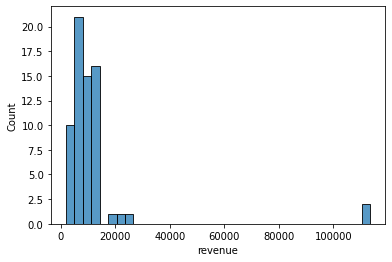

In [85]:
#построим график распределения выручки в тестовой группе
sns.histplot (test_premium_revenue.revenue)

In [86]:
# также проверим его с помощью теста на нормальность
normaltest (test_premium_revenue.revenue)

NormaltestResult(statistic=106.54140302751497, pvalue=7.325348408699843e-24)

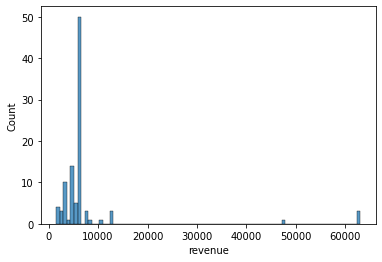

In [87]:
#построим график распределения выручки в контрольной группе 1
sns.histplot (control_1_premium_revenue.revenue)

In [88]:
# видно, что распределение далеко от нормального, но дополнительно проверим это с помощью теста библиотеки scipy
normaltest (control_1_premium_revenue.revenue)

NormaltestResult(statistic=124.21739942622756, pvalue=1.0630028683665471e-27)

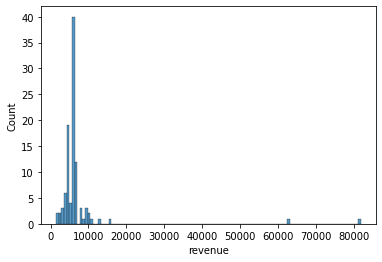

In [89]:
#построим график распределения выручки в контрольной группе 2
sns.histplot (control_2_premium_revenue.revenue)

In [90]:
# также проверим его с помощью теста на нормальность
normaltest (control_2_premium_revenue.revenue)

NormaltestResult(statistic=171.9952413403099, pvalue=4.4844365763572774e-38)

Видим, что распределение во всех трёх группах не подходит под определение нормальных. Можем воспользоваться критерием Манна-Уитни.

In [91]:
# критерий Манна-Уитни для тестовой и первой контрольной групп
mannwhitneyu (test_premium_revenue.revenue,\
             control_1_premium_revenue.revenue)

MannwhitneyuResult(statistic=4949.5, pvalue=5.962668862144281e-08)

In [92]:
# критерий Манна-Уитни для тестовой и второй контрольной групп
mannwhitneyu (test_premium_revenue.revenue,\
             control_2_premium_revenue.revenue)

MannwhitneyuResult(statistic=5034.5, pvalue=1.5494296303089133e-07)

Видим, что в соответствии с критерием Манна-Уитни стат. значимые различия между тестовой и контрольной группами есть. Так как критерий Манна-Уитни довольно сложно интерпретировать, воспользуемся бутстрапом и сравним медианы, чтобы подтвердить результаты.

In [93]:
# выведем медианы по выручкам в группах для наглядности
print ('Медиана выручки тестовой группы - ', np.median(test_premium_revenue.revenue))
print ('Медиана выручки контрольной группы 1 - ', np.median(control_1_premium_revenue.revenue))
print ('Медиана выручки контрольной группы 2 - ', np.median(control_2_premium_revenue.revenue))

Медиана выручки тестовой группы -  8268.0
Медиана выручки контрольной группы 1 -  6292.0
Медиана выручки контрольной группы 2 -  6292.0


In [94]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительные интервалы 95% для медианы
# тестовой и контрольных групп
print ('Доверительный интервал медианы тестовой группы - ', \
        pg.compute_bootci (x = test_premium_revenue.revenue,\
        func= np.median))
print ('Доверительный интервал медианы контрольной группы 1 - ', \
       pg.compute_bootci (x = control_1_premium_revenue.revenue,\
        func= np.median))
print ('Доверительный интервал медианы контрольной группы 2 - ', \
       pg.compute_bootci (x = control_2_premium_revenue.revenue,\
        func= np.median))

Доверительный интервал медианы тестовой группы -  [7774. 9217.]
Доверительный интервал медианы контрольной группы 1 -  [6292. 6292.]
Доверительный интервал медианы контрольной группы 2 -  [6292. 6292.]


Значения 95%-доверительный интервалов для медианы выручки в тестовой группе статистически значимо выше, чем в обеих контрольных группах. Делаем вывод, что выручка тестовой группы статистически значимо выше.

## 2 Анализ изменения количества пользователей, купивших премиум-подписку

Для того, чтобы сравнить изменения, нужно построить кросс-таблицы с пользователями тестовой и контрольных групп, купивших и не купивших премиум-подписку.

In [32]:
# в таблицы по группам добавим идентификатор для каждой группы
users_test_with_transactions ['group_type'] = 'test'
users_control_1_with_transactions ['group_type'] = 'control_1'
users_control_2_with_transactions ['group_type'] = 'control_2'

In [33]:
# создадим кросс-таблицу, в которой объединим значения всех групп
# нас итересует количество пользователей с типом продукта 'premium_no_trial' в сравнении с остальными типами
cross_table_for_groups = pd.concat ([users_test_with_transactions, users_control_1_with_transactions, users_control_2_with_transactions])
cross_table_for_groups = cross_table_for_groups.groupby (['group_type', 'product_type'], as_index = False)\
                            .agg ({'uid':'count'})\
                            .rename (columns = {'uid':'test_count'})\
                            .pivot (index = 'group_type', columns = 'product_type', values = 'test_count')

In [34]:
# в отдельном столбце посчитаем всех остальных пользователей, которые не оплачивали премиум-подписку
cross_table_for_groups ['not_paid'] = cross_table_for_groups.coins + cross_table_for_groups.other_type\
                                        + cross_table_for_groups.trial_premium

In [35]:
# удалим лишние столбцы
cross_table_for_groups = cross_table_for_groups.drop (columns = ['coins', 'other_type', 'trial_premium']).reset_index()

In [36]:
# получаем таблицу для анализа
cross_table_for_groups

product_type,group_type,premium_no_trial,not_paid
0,control_1,106,271
1,control_2,107,221
2,test,76,197


В данном случае мы воспользуемся критерием хи-квадрат для сравнения данных в кросс-таблицах.

In [37]:
# хи-квадрат для тестовой и контрольной группы 1
chi2_contingency (cross_table_for_groups.query ('group_type in ["test", "control_1"]').set_index ('group_type'))

(0.0,
 1.0,
 1,
 array([[105.56, 271.44],
        [ 76.44, 196.56]]))

In [38]:
# хи-квадрат для тестовой и контрольной группы 2
chi2_contingency (cross_table_for_groups.query ('group_type in ["test", "control_2"]').set_index ('group_type'))

(1.391624860978896,
 0.23813089109971813,
 1,
 array([[ 99.87354409, 228.12645591],
        [ 83.12645591, 189.87354409]]))

Анализ методом хи-квадрат не показал статистически значимых различий в количестве пользователей, купивших подписку, между группами.

## 3 Анализ изменения количества прошедших дней до покупки премиума

Мы можем оценить, насколько быстро пользователи решают купить премиум-подписку, и поменялась ли эта цифра.

In [39]:
# посчитаем количество дней, прошедших до покупки премиума, в тестовой группе
test_days_before_premium = users_test_with_transactions\
                            .query ('product_type == "premium_no_trial" and paid_at > joined_at')\
                            .groupby (['uid', 'joined_at'], as_index = False)\
                            .agg ({'paid_at':'min'})
test_days_before_premium ['days_have_passed'] = (test_days_before_premium.paid_at - test_days_before_premium.joined_at).dt.days
test_days_before_premium.head()

,uid,joined_at,paid_at,days_have_passed
0,891071157,2017-10-11 10:20:00,2017-10-11 16:37:00,0
1,891152790,2017-08-11 18:39:00,2017-10-11 11:29:00,60
2,891178380,2017-08-11 03:54:00,2017-09-11 21:53:00,31
3,891222282,2017-07-11 09:26:00,2017-07-11 09:38:00,0
4,891291531,2017-06-11 04:34:00,2017-07-11 21:25:00,30


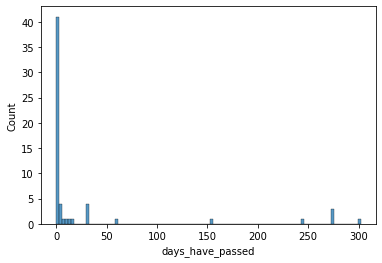

In [40]:
# построим график распределения по столбцу с количеством прошедших дней
sns.histplot (test_days_before_premium.days_have_passed)

In [41]:
# посчитаем количество дней, прошедших до покупки премиума, в контрольной группе 1
control_1_days_before_premium = users_control_1_with_transactions\
                            .query ('product_type == "premium_no_trial" and paid_at > joined_at')\
                            .groupby (['uid', 'joined_at'], as_index = False)\
                            .agg ({'paid_at':'min'})
control_1_days_before_premium ['days_have_passed'] = (control_1_days_before_premium.paid_at - control_1_days_before_premium.joined_at).dt.days
control_1_days_before_premium.head()

,uid,joined_at,paid_at,days_have_passed
0,891092322.0,2017-09-11 22:48:00,2017-10-11 01:18:00,29
1,891120969.0,2017-09-11 12:24:00,2017-09-11 12:40:00,0
2,891130164.0,2017-09-11 07:37:00,2017-11-13 03:53:00,62
3,891131061.0,2017-09-11 07:04:00,2017-09-11 23:38:00,0
4,891142386.0,2017-08-11 23:02:00,2017-08-11 23:38:00,0


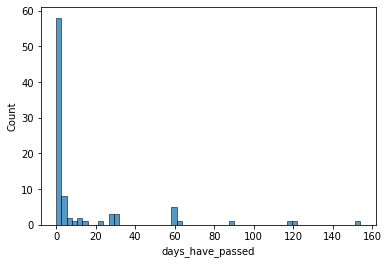

In [42]:
# построим график распределения по столбцу с количеством прошедших дней
sns.histplot (control_1_days_before_premium.days_have_passed)

In [43]:
# посчитаем количество дней, прошедших до покупки премиума, в контрольной группе 2
control_2_days_before_premium = users_control_2_with_transactions\
                            .query ('product_type == "premium_no_trial" and paid_at > joined_at')\
                            .groupby (['uid', 'joined_at'], as_index = False)\
                            .agg ({'paid_at':'min'})
control_2_days_before_premium ['days_have_passed'] = (control_2_days_before_premium.paid_at - control_2_days_before_premium.joined_at).dt.days
control_2_days_before_premium.head()

,uid,joined_at,paid_at,days_have_passed
0,891068079,2017-10-11 11:45:00,2017-12-11 15:23:00,61
1,891077727,2017-10-11 06:38:00,2017-10-11 16:33:00,0
2,891112263,2017-09-11 15:59:00,2017-11-11 14:55:00,60
3,891136632,2017-09-11 02:17:00,2017-11-13 21:55:00,63
4,891143379,2017-08-11 22:35:00,2017-11-14 19:59:00,94


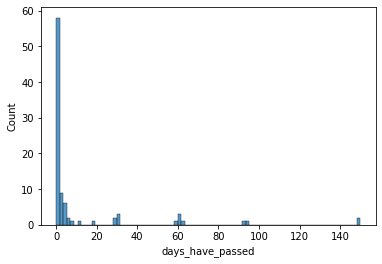

In [44]:
# построим график распределения по столбцу с количеством прошедших дней
sns.histplot (control_2_days_before_premium.days_have_passed)

По графикам распределения количества прошедших дней видно, что распределения далеки от нормальных. Воспользуемся методом бутстрап, чтобы сравнить группы.

In [70]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительные интервалы 95% для медианы
# тестовой и контрольных групп
print ('Доверительный интервал медианы тестовой группы - ', \
        pg.compute_bootci (x = test_days_before_premium.days_have_passed,\
        func= np.median))
print ('Доверительный интервал медианы контрольной группы 1 - ', \
       pg.compute_bootci (x = control_1_days_before_premium.days_have_passed,\
        func= np.median))
print ('Доверительный интервал медианы контрольной группы 2 - ', \
       pg.compute_bootci (x = control_2_days_before_premium.days_have_passed,\
        func= np.median))

Доверительный интервал медианы тестовой группы -  [0. 1.]
Доверительный интервал медианы контрольной группы 1 -  [0. 1.]
Доверительный интервал медианы контрольной группы 2 -  [0. 1.]


Сравнение доверительных интервалов медиан по группам не показало статистически значимых различий. Значит, анализ изменения количества прошедших дней до покупки премиума не дал результатов.

## 4 Анализ изменения количества покупок премиума одним пользователем

Сравним, как изменилось поведение пользователей в плане покупки платного премиума. Стали ли они чаще платить за эту возможность.

In [59]:
# в тестовой группе найдём для каждого пользователя количество оплат платной премиум-подписки
test_count_of_premium_payments = users_test_with_transactions.query ('product_type == "premium_no_trial"')\
                            .groupby ('uid')\
                            .agg ({'paid_at':'count'})\
                            .rename (columns = {'paid_at':'count_of_payments'})
test_count_of_premium_payments.head()

,count_of_payments
uid,
891071157,1
891152790,1
891178380,1
891222282,1
891291531,1


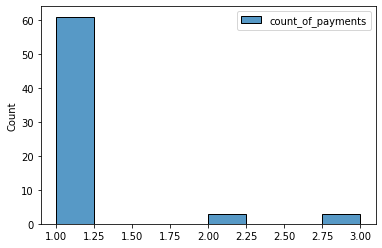

In [63]:
# построим график распределения количества оплат премиума для тестовой группы
sns.histplot (test_count_of_premium_payments)

In [60]:
# в контрольной группе 1 найдём для каждого пользователя количество оплат платной премиум-подписки
control_1_count_of_premium_payments = users_control_1_with_transactions.query ('product_type == "premium_no_trial"')\
                            .groupby ('uid')\
                            .agg ({'paid_at':'count'})\
                            .rename (columns = {'paid_at':'count_of_payments'})
control_1_count_of_premium_payments.head()

,count_of_payments
uid,
891092322.0,1
891120969.0,1
891130164.0,1
891131061.0,1
891142386.0,1


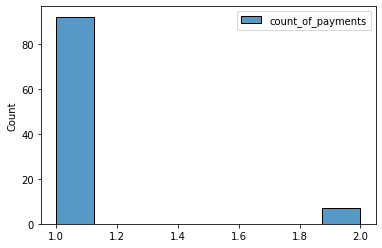

In [65]:
# построим график распределения количества оплат премиума для контрольной группы 1
sns.histplot (control_1_count_of_premium_payments)

In [61]:
# в контрольной группе 1 найдём для каждого пользователя количество оплат платной премиум-подписки
control_2_count_of_premium_payments = users_control_2_with_transactions.query ('product_type == "premium_no_trial"')\
                            .groupby ('uid')\
                            .agg ({'paid_at':'count'})\
                            .rename (columns = {'paid_at':'count_of_payments'})
control_2_count_of_premium_payments.head()

,count_of_payments
uid,
891068079,1
891077727,1
891112263,1
891136632,1
891143379,1


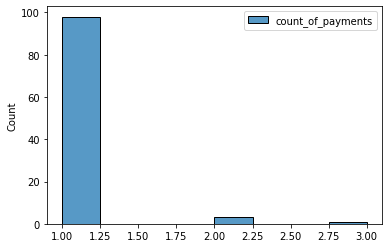

In [66]:
# построим график распределения количества оплат премиума для контрольной группы 2
sns.histplot (control_2_count_of_premium_payments)

На графиках видно, что распределения не нормальные. Для сравнения их между собой воспользуемся бутстрапом и будем сравнивать средние арифметические, так как больших выбросов не наблюдается.

In [67]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительные интервалы 95% для среднего
# тестовой и контрольных групп
print ('Доверительный интервал среднего тестовой группы - ', \
        pg.compute_bootci (x = test_count_of_premium_payments.count_of_payments,\
        func= np.mean))
print ('Доверительный интервал среднего контрольной группы 1 - ', \
       pg.compute_bootci (x = control_1_count_of_premium_payments.count_of_payments,\
        func= np.mean))
print ('Доверительный интервал среднего контрольной группы 2 - ', \
       pg.compute_bootci (x = control_2_count_of_premium_payments.count_of_payments,\
        func= np.mean))

Доверительный интервал среднего тестовой группы -  [1.04 1.25]
Доверительный интервал среднего контрольной группы 1 -  [1.03 1.12]
Доверительный интервал среднего контрольной группы 2 -  [1.01 1.12]


## Выводы по анализу результатов A/B-теста

Анализ показал, что статистически значимых различий не выявлено в:
1. Количестве пользователей, купивших премиум-подписку
2. Количестве дней с момента регистрации до покупки премиум-подписки
3. Количестве покупок премиум-подписки пользователями, которые уже купили премиум хотя бы один раз.

При этом важным является то, что выявлено статистически значимое увеличение прибыли за покупки премиум-подписки в тестовой группе по сравнению с двумя контрольными группами. 

Это позволяет сделать вывод, что эксперимент по изменению цены премиум-подписки оказался успешен. И для бизнеса будет выгодным раскатать новую версию приложения на остальных пользователей.